In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import *
from lxml import etree
from tqdm.notebook import tqdm
from datetime import datetime
import time
import torch
import pandas as pd
import os

In [15]:
base_url = "https://tieba.baidu.com/f?kw={}&ie=utf-8&pn={}"
herf_base_url = "https://tieba.baidu.com{}"
folder = "data/{}"
name = "弱智"
chrome_options = Options()
chrome_options.page_load_strategy = 'eager'
brw=webdriver.Chrome(options=chrome_options)
brw.implicitly_wait(2)

In [21]:
def get_html(url):
    # start_time = time.time()
    brw.get(url)
    # check whether is forbidden page or 安全验证 or empty page
    # passMod_dialog-header
    while brw.title == '百度安全验证':
        solve_verify()
        time.sleep(5)
    # static page
    content = etree.HTML(brw.page_source.replace("<!--", "").replace("-->", ""))
    title = content.xpath('//div[contains(@class,"threadlist_title pull_left j_th_tit")]/a/@title')
    assert len(title) > 2, "the length of the list of title is larger than 2"
    author = content.xpath('//div[@class="t_con cleafix"]/div[@class="col2_right j_threadlist_li_right "]/div[@class="threadlist_lz clearfix"]/div[contains(@class,"threadlist_author pull_right")]/span[contains(@class,"tb_icon_author ")]/@title')
    reply = content.xpath('//div[@class="t_con cleafix"]/div[@class="col2_left j_threadlist_li_left"]/span[@class="threadlist_rep_num center_text" and @title="回复"]/text()')
    href = content.xpath('//div[@class="t_con cleafix"]/div[@class="col2_right j_threadlist_li_right "]/div[@class="threadlist_lz clearfix"]/div[contains(@class,"threadlist_title pull_left j_th_tit")]/a/@href')
    detail_path = content.xpath('//div[contains(@class,"threadlist_abs")]')
    ddd = len(title) - len(detail_path)
    batch = []
    for i in range(len(href)):
        info = {'title': title[i], 
                "detail": ' '.join(detail_path[i-ddd].xpath('.//text()')).strip() if i>=ddd else '',
                'author': author[i].replace('主题作者: ', ''),
                'num_reply': int(reply[i]),
                'href': herf_base_url.format(href[i])}
        batch.append(info)
    return batch

def get_page(page: int, name: str):
    assert page>0
    assert name is not None
    url = base_url.format(name, (page-1)*50)
    batch = get_html(url)
    df = pd.DataFrame.from_records(batch)
    # save df to th folder
    df.to_csv(os.path.join(folder.format(name), f'{page}.csv'), index=False)

def get_all_pages(name: str, start_page:int=1, total_page: int=2002, delta: int=1):
    assert name is not None
    pbar = tqdm(range(start_page, total_page+1))
    for page in pbar:
        pbar.set_postfix({"Processed": page-1})
        try:
            get_page(page, name)
            time.sleep(delta)
        except:
            print(f'error at page {page}')
            break

In [24]:
get_all_pages(name, 957, 957, delta=0.5)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# page 44
# https://tieba.baidu.com/f?kw=%E5%BC%B1%E6%99%BA&ie=utf-8&pn=47800被限制访问了

ROT 验证码

In [4]:
import torch.nn as nn
from torch import Tensor
from torchvision import models
import torch

class RotNetR(nn.Module):
    """
    Args:
        train (bool, optional): True to load the pretrained parameters. Defaults to True.

    Note:
        impl: `rotnet_street_view_resnet50` in https://github.com/d4nst/RotNet but with `RegNet_Y_3_2GF` as its backbone
    """

    def __init__(self, cls_num: int = 180, train: bool = True) -> None:
        super(RotNetR, self).__init__()

        self.cls_num = cls_num

        self.backbone = models.regnet_y_3_2gf()

        fc_channels = self.backbone.fc.in_features
        del self.backbone.fc
        self.backbone.fc = nn.Linear(fc_channels, cls_num)

        if train:
            nn.init.kaiming_normal_(self.backbone.fc.weight)
            nn.init.zeros_(self.backbone.fc.bias)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x (Tensor): img_tensor ([N,C,H,W]=[batch_size,3,224,224], dtype=float32, range=[0.0,1.0))

        Returns:
            Tensor: predict result ([N,C]=[batch_size,cls_num), dtype=float32, range=[0.0,1.0))
        """

        x = self.backbone.forward(x)

        return x

    def predict(self, img_ts: Tensor) -> float:
        """
        Predict the counter clockwise rotation angle.

        Args:
            img_ts (Tensor): img_tensor ([C,H,W]=[3,224,224], dtype=float32, range=[0.0,1.0))

        Returns:
            float: predict result. range=[0.0,1.0)

        Note:
            Use Image.rotate(-ret * 360) to recover the image.
        """

        img_ts = img_ts.unsqueeze_(0)

        onehot_ts = self.backbone.forward(img_ts)
        angle = float(onehot_ts.cpu().argmax(1).item()) / self.cls_num

        return angle

from cap import *
def process_captcha(img: Image, target_size: int = 224, norm: Normalize = DEFAULT_NORM) -> Tensor:
    """
    Convert captcha image into tensor.

    Args:
        img (Image): captcha image (square with border)
        target_size (int, optional): target size. Defaults to `DEFAULT_TARGET_SIZE`.
        norm (Normalize, optional): normalize policy. Defaults to `DEFAULT_NORM`.

    Returns:
        Tensor: tensor ([C,H,W]=[3,target_size,target_size], dtype=float32, range=[0.0,1.0))
    """
 
    img = img.convert('RGB')
    img_ts = to_tensor(img)
    img_ts = strip_border(img_ts)
    img_ts = u8_to_float32(img_ts)
    img_ts = square_resize(img_ts, target_size)
    img_ts = norm(img_ts)

    return img_ts

In [7]:
from PIL import Image

img = Image.open('1.jpg')
print(to_tensor(img))
# print(process_captcha(img))

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)


In [17]:
# deal with rot
import requests
import requests
from PIL import Image
from io import BytesIO
from selenium.webdriver import ActionChains

# download CNN model from huggingface
# model = RotNetR(cls_num=180, train=False)
# model_path = 'best.pth'
# model.load_state_dict(torch.load(str(model_path), map_location=torch.device('cpu')))
model = torch.load('rot_net.pth')
model.eval()

def get_img(url):
    header = {
        "Host": "passport.baidu.com",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:93.0) Gecko/20100101 Firefox/93.0",
        "Accept": "image/avif,image/webp,*/*",
        "Accept-Language": "zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2",
        "Accept-Encoding": "gzip, deflate, br",
        "Referer": "https://wappass.baidu.com/",
        "Connection": "keep-alive",
        "Cookie": "BAIDUID=7999A864ECB04BF96DC42141762CF08C:FG=1; BIDUPSID=310DBCE84D6A8388D88171F49E098D2D; PSTM=1634536706; BDRCVFR[gltLrB7qNCt]=mk3SLVN4HKm; delPer=0; PSINO=7; H_PS_PSSID=34837_34439_34067_31254_34741_34525_34584_34504_34706_34806_34578_26350_34725_22158_34691_34671; BDORZ=FFFB88E999055A3F8A630C64834BD6D0",
        "Sec-Fetch-Dest": "image",
        "Sec-Fetch-Mode": "no-cors",
        "Sec-Fetch-Site": "same-site",
        "Pragma": "no-cache",
        "Cache-Control": "no-cache",
    }
    response = requests.get(url=url,headers=header)
 
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
    return img

# brw.get('https://wappass.baidu.com/static/captcha/tuxing.html?ak=33c48884b7df83d4230e07cbcd0d07fd&backurl=https%3A%2F%2Faiqicha.baidu.com&timestamp=1634288600&signature=02fafac36a570b03a3c9100ec68b02e5')
def solve_verify():
    spin_button = WebDriverWait(brw, 10).until(
        EC.presence_of_element_located((By.XPATH, '//div[contains(@class,"passMod_slide-btn ")]'))
    )
    img_src = WebDriverWait(brw, 10).until(
        EC.presence_of_element_located((By.XPATH, '//img[contains(@class,"passMod_spin-background")]'))
    ).get_attribute('src')
    
    img = get_img(img_src)
    def comp_rot(img):
        return model.predict(process_captcha(img)) * 250
    move_x = comp_rot(img)
    # print(move_x)
    action = ActionChains(brw)
    action.click_and_hold(spin_button).perform()
    action.move_by_offset(move_x, 0).perform()
    action.release().perform()

In [13]:
import pandas as pd
df = pd.read_csv('data/弱智/50.csv')
df.head()

,title,detail,author,num_reply,href
0,遨游在知识的海洋里会被淹s吗？？？,NaN,lhxyyds1313133,0,https://tieba.baidu.com/p/8679512653
1,既然未成年人处处受到限制,那为什么我们不可以把未成年人作为成人用品呢？🤔,胡xx520,0,https://tieba.baidu.com/p/8679506209
2,人类的进化史就是一猿死万猿生,NaN,贴吧用户_0DQKD8A,1,https://tieba.baidu.com/p/8676650047
3,传统是过期的流行，流行是新鲜的传统,NaN,贴吧用户_ab8PGbS,5,https://tieba.baidu.com/p/8678663856
4,王警官听说犯人上有老下有小十分同情,把一家关在一间牢房方便犯人照顾,凡是人类,2,https://tieba.baidu.com/p/8678705819


In [25]:
# concat all the odd table to one
import pandas as pd
i = 1
df1 = pd.read_csv('data/弱智/1.csv')
while i < 2001:
    i += 2
    df = pd.read_csv(f'data/弱智/{i}.csv')
    df1 = pd.concat([df1, df], ignore_index=True)

i=2
df2 = pd.read_csv('data/弱智/2.csv')
while i < 2000: 
    i += 2
    df = pd.read_csv(f'data/弱智/{i}.csv')
    df2 = pd.concat([df2, df], ignore_index=True)

In [48]:
df1.info()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46433 entries, 0 to 46432
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      46433 non-null  object
 1   detail     28673 non-null  object
 2   author     46428 non-null  object
 3   num_reply  46433 non-null  int64 
 4   href       46433 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46608 entries, 0 to 46607
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      46608 non-null  object
 1   detail     28615 non-null  object
 2   author     46601 non-null  object
 3   num_reply  46608 non-null  int64 
 4   href       46608 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [50]:
46433+46608

93041

In [83]:
df = pd.merge(df1, df2, how='outer', on=df1.columns.tolist())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92509 entries, 0 to 92508
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      92509 non-null  object
 1   detail     56971 non-null  object
 2   author     92499 non-null  object
 3   num_reply  92509 non-null  int64 
 4   href       92509 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


In [52]:
df.to_csv(os.path.join(folder.format(name), f'raw_data.csv'), index=False)

In [84]:
# sort by num_reply
# df = df.sort_values(by='num_reply', ascending=False)
# 加一个id列
df['id'] = df.index.tolist()
# 把id列移到第一个
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()


,id,title,detail,author,num_reply,href
0,0,排队的时候发现自己被陌生人尾随了该怎么报警,NaN,摧铩,754,https://tieba.baidu.com/p/8090180053
1,1,我被两个护士架在房间内，她们是不是认我当将军了？,NaN,-白给十字军-,7,https://tieba.baidu.com/p/8712781320
2,2,整天在工作时胡思乱想，精神大爆发怎么办？,正在看规范书，准备下午工作或出报告，但看的看的，突然在思考一个问题... 可口可乐混盐汽水陪...,童封繁,4,https://tieba.baidu.com/p/8712953472
3,3,如果两个会读心术的人互相读心，他们读的是谁的心？,NaN,贴吧用户_aJtEX5X,0,https://tieba.baidu.com/p/8712961822
4,4,你只准备了5杯水，来了一亿个领导,你应该怎么分配这些水,冰糖肘子😜,2361,https://tieba.baidu.com/p/8703341221


In [76]:
df1w = df[df["num_reply"]<100]
df1w = df1w[df1w["num_reply"]>5]

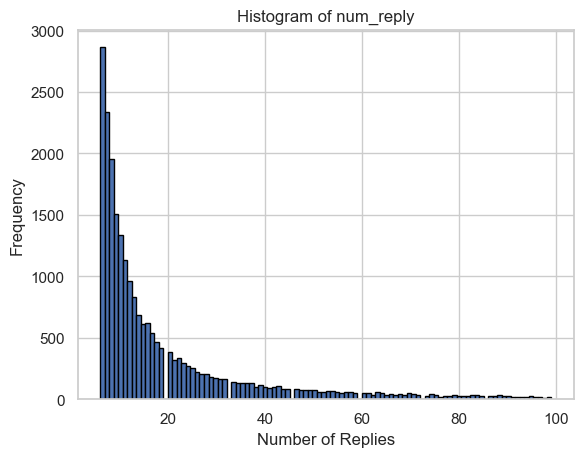

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.hist(df1w['num_reply'], bins=100, edgecolor='black')
plt.title('Histogram of num_reply')
plt.xlabel('Number of Replies')
plt.ylabel('Frequency')
plt.show()


In [14]:
import pandas as pd
df = pd.read_csv('data/弱智/wisdomBar_raw.csv')

In [18]:
df = df.sort_values(by='num_reply', ascending=False)
df[:50]['title']

46464       弱智吧突击考试，共20题，每题5分，满分100分，含作文
47861                       回忆向：我在青龙山的日子
161                   年度总结：弱吧2021年度306佳贴
51697                              正常人日记
121                         鸡柳是鸡身上哪个部位啊？
303                       弱智吧2022年度365佳贴
48044       【贴图】弱智吧大神们快来认领！经典语录漫画版《一句笑话》
46462      弱智吧官方水楼！注意！从今天起在其他贴子里水经验将概率封禁
157                         这两款香水哪一个比较好阿
46454                         弱智吧神回复第三期。
46469                           都成流量密码了都
58                       有没有会盲文的摸一下什么意思？
46509                        有哪些违法行为是合法的
45                只切一刀，如何把四个橘子平均分给四个小朋友？
6968      谁能想到，这名年仅16岁的少女四年前只是一名年仅12岁的少女
46496                  我用的是晨光的笔，那么你们都是啥笔
23080          樟脑丸是我吃过最难吃的硬糖有奇怪的味道怎么还有人买
7853                     《一颗无花果，千军万马来相见》
6011                   我们弱智应该知道的100条人生格言
46592     兄弟们，没球拍了，同学把他的拍锁 上了不让我用了怎么办😡😡😡
46458         现在的学历歧视太严重了，我说我对象在上小学一堆人骂我
92                 弱智吧19岁生日快乐！近年神回复鉴赏大会！
5912                  严重的恐高症害得我终身无法低头捡到钱
1312               出生前爸爸没了叫遗腹子，那妈妈没了叫什么？
47144           

In [13]:
# find all the title contain "月亮"
df[df['title'].str.contains('怎么样才能确保尸体活着')]

,title,detail,author,num_reply,href
